# Clustering Songs in a Playlist by Genre

In [ ]:
import os
import time
import spotipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import AgglomerativeClustering
from spotipy.oauth2 import SpotifyClientCredentials
from dotenv import load_dotenv


load_dotenv()
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id=os.getenv("SPOTIPY_CLIENT_ID"),
    client_secret=os.getenv("SPOTIPY_CLIENT_SECRET")
))


In [ ]:
def get_playlist_track_ids(playlist_id):
    track_ids = []
    results = sp.playlist_items(playlist_id, additional_types=['track'])
    while results:
        for item in results['items']:
            track = item['track']
            if track and track.get('id'):
                track_ids.append(track['id'])
        if results['next']:
            results = sp.next(results)
            time.sleep(0.5)
        else:
            break
    return list(set(track_ids)) 

In [10]:
def get_track_and_genre_info(track_ids):
    tracks_data = []
    for tid in track_ids:
        try:
            track = sp.track(tid)
            artist = track['artists'][0]
            artist_info = sp.artist(artist['id'])
            genres = artist_info.get('genres', [])
            tracks_data.append({
                'track_id': track['id'],
                'track_name': track['name'],
                'artist_name': artist['name'],
                'artist_id': artist['id'],
                'genres': genres
            })
            time.sleep(0.1)
        except Exception as e:
            print(f"Error with track {tid}: {e}")
    return pd.DataFrame(tracks_data)


In [ ]:
def cluster_tracks_by_genre(df_tracks, n_clusters=4):
    df_tracks = df_tracks[df_tracks['genres'].map(len) > 0]
    mlb = MultiLabelBinarizer()
    genre_matrix = mlb.fit_transform(df_tracks['genres'])
    genre_df = pd.DataFrame(genre_matrix, columns=mlb.classes_)

    distance_matrix = cosine_distances(genre_df)

    clustering = AgglomerativeClustering(
        metric='precomputed', 
        linkage='average',
        n_clusters=n_clusters
    )
    df_tracks['cluster'] = clustering.fit_predict(distance_matrix)
    return df_tracks


In [12]:
def visualize_clusters(df_tracks):
    sns.set(style="whitegrid")
    plt.figure(figsize=(6, 4))
    sns.countplot(x='cluster', data=df_tracks, palette='Set2')
    plt.title('Number of Songs per Genre Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Song Count')
    plt.tight_layout()
    plt.show()

def print_cluster_samples(df_tracks, n_clusters):
    for c in range(n_clusters):
        print(f"\n🎧 Cluster {c}:")
        cluster_df = df_tracks[df_tracks['cluster'] == c][['track_name', 'artist_name', 'genres']]
        print(cluster_df.head(5).to_string(index=False))



🎧 Cluster 0:
                                      track_name      artist_name                              genres
Lose Yourself to Dance (feat. Pharrell Williams)        Daft Punk [french house, electronic, electro]
                               Don't You Want Me The Human League                [new wave, synthpop]
                                  Memphis, Pt. 2          AG Club               [alternative hip hop]
            Choppa Won't Miss (feat. Young Thug)    Playboi Carti                          [rage rap]
                                      Deceptacon         Le Tigre                      [electroclash]

🎧 Cluster 1:
                                  track_name          artist_name                                                        genres
                                      PRIDE.       Kendrick Lamar                                 [hip hop, west coast hip hop]
                                      HYAENA         Travis Scott                                       

/var/folders/kw/g1163sld0bng6q70v4hldvtw0000gn/T/ipykernel_26012/2574418868.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tracks['cluster'] = clustering.fit_predict(distance_matrix)


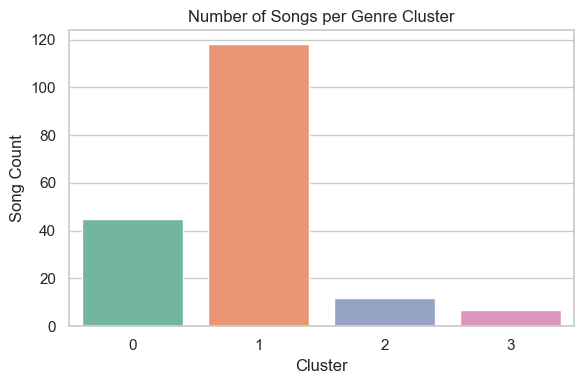

In [ ]:
playlist_id = "79mXvSd3YpbxeAztsIBz7z" 
track_ids = get_playlist_track_ids(playlist_id)
df_tracks = get_track_and_genre_info(track_ids)
df_clustered = cluster_tracks_by_genre(df_tracks, n_clusters=4)

print_cluster_samples(df_clustered, n_clusters=4)
visualize_clusters(df_clustered)


df_clustered.to_csv("playlist_genre_clusters.csv", index=False)
